## Population Segmentation with SageMaker

- In this notebook, you'll employ two unsupervised learning algorithms to do **population segmentation**. 
- Population segmentation aims to find natural groupings in population data that reveal some feature-level similarities between different regions in the US.

- Using **principal component analysis** (PCA) you will reduce the dimensionality of the original census data. 
- Then use **k-means clustering** to assign each US county to a particular cluster based on where a county lies in component space.
- How each cluster is arranged in component space can tell you which US counties are most similar and what demographic traits define that similarity
- this information is most often used to inform targeted, marketing campaigns that want to appeal to a specific group of people.
- This cluster information is also useful for learning more about a population by revealing patterns between regions that you otherwise may not have noticed.

## US Census Data

- You'll be using data collected by the [US Census](https://en.wikipedia.org/wiki/United_States_Census), which aims to count the US population, recording demographic traits about labor, age, population, and so on, for each county in the US.
- The bulk of this notebook was taken from an existing SageMaker example notebook and [blog post](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/), and I've broken it down further into demonstrations and exercises for you to complete.

## Machine Learning Workflow

- To implement population segmentation, you'll go through a number of steps:
* Data loading and exploration
* Data cleaning and pre-processing 
* Dimensionality reduction with PCA
* Feature engineering and data transformation
* Clustering transformed data with k-means
* Extracting trained model attributes and visualizing k clusters

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
# sagemaker libraries
import boto3
import sagemaker

## Loading the Data from Amazon S3

In [3]:
# boto3 client to interact with S3 data
s3_client = boto3.client('s3')

# S3 bucket name
bucket_name='aws-ml-blog-sagemaker-census-segmentation'

In [5]:
# get a list of objects in the bucket
obj_list=s3_client.list_objects(Bucket=bucket_name)

# print object(s)in S3 bucket
files=[]
for contents in obj_list['Contents']:
    files.append(contents['Key'])
    
print(files)

['Census_Data_for_SageMaker.csv']


In [6]:
file_name=files[0]
print(file_name)

Census_Data_for_SageMaker.csv


## Retrieve the data file from S3

In [7]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
display(data_object)

{'ResponseMetadata': {'RequestId': 'EE494A27DF11E97C',
  'HostId': 'I9i1Z8cCS9JcMBRkX7SEzj8Uz9wFofqLj5c2eJryM8x5xLacPRdPxUCCzh3EKoWEmcfGjNyRVV0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'I9i1Z8cCS9JcMBRkX7SEzj8Uz9wFofqLj5c2eJryM8x5xLacPRdPxUCCzh3EKoWEmcfGjNyRVV0=',
   'x-amz-request-id': 'EE494A27DF11E97C',
   'date': 'Mon, 19 Aug 2019 17:10:04 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f68f6361a58>}

In [8]:
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


In [9]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
counties_df = pd.read_csv(data_stream, header=0, delimiter=",") 
counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Exploratory Data Analysis (EDA)

In [10]:
#get the shape of the data
print('(orig) rows, cols: ', counties_df.shape)

# drop any incomplete data
clean_counties_df = counties_df.dropna(axis=0)
print('(clean) rows, cols: ', clean_counties_df.shape)

(orig) rows, cols:  (3220, 37)
(clean) rows, cols:  (3218, 37)


## Create a new DataFrame, indexed by 'State-County'

```
                TotalPop	 Men	  Women	Hispanic	...
                
Alabama-Autauga	55221	 26745	28476	2.6         ...
Alabama-Baldwin	195121	95314	99807	4.5         ...
Alabama-Barbour	26932	 14497	12435	4.6         ...
...

```

In [11]:
clean_counties_df.index=clean_counties_df['State'] + "-" + clean_counties_df['County']
clean_counties_df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [15]:
# drop the old State and County columns and the CensusId column
drop=["CensusId" , "State" , "County"]
clean_counties_df = clean_counties_df.drop(columns=drop)
clean_counties_df.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [16]:
# features
features_list = clean_counties_df.columns.values #.values to select
print('Features: \n', features_list)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Visualizing the Data

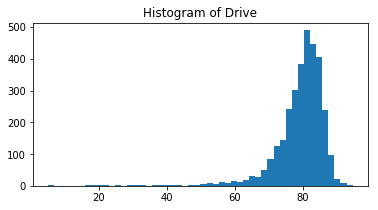

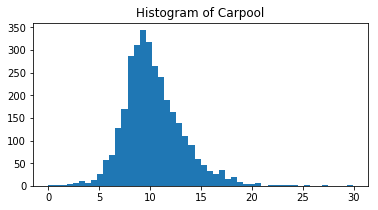

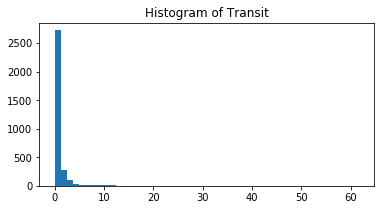

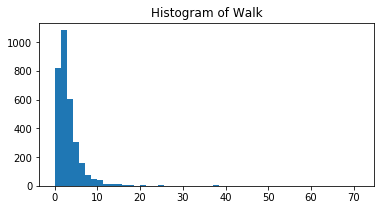

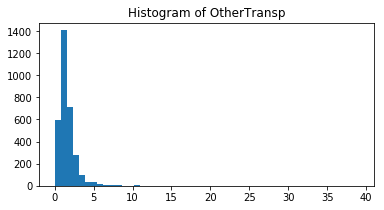

In [18]:
transport_list = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp']
n_bins = 50 

for column_name in transport_list:
    #so each feature will have its own histogram
    
    ax=plt.subplots(figsize=(6,3))    
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)    
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()

## Normalize the data with MinMaxScaler()

In [20]:
# scale numerical features into a normalized range, 0-1
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

# store them in new dataframe
counties_scaled=pd.DataFrame(scaler.fit_transform(clean_counties_df.astype(float)))
counties_scaled.columns=clean_counties_df.columns
counties_scaled.index=clean_counties_df.index
counties_scaled.head()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,0.005475,0.005381,0.005566,0.026026,0.759519,0.215367,0.004343,0.024038,0.0,0.006702,...,0.007022,0.033248,0.048387,0.552430,0.005139,0.750000,0.250000,0.150273,0.000000,0.208219
Alabama-Baldwin,0.019411,0.019246,0.019572,0.045045,0.832665,0.110594,0.006515,0.016827,0.0,0.024393,...,0.014045,0.035806,0.104839,0.549872,0.018507,0.884354,0.107616,0.158470,0.040816,0.205479
Alabama-Barbour,0.002656,0.002904,0.002416,0.046046,0.462926,0.543655,0.002172,0.009615,0.0,0.003393,...,0.025281,0.038363,0.043011,0.491049,0.001819,0.719388,0.248344,0.199454,0.010204,0.482192
Alabama-Bibb,0.002225,0.002414,0.002042,0.022022,0.746493,0.249127,0.004343,0.002404,0.0,0.002860,...,0.008427,0.038363,0.018817,0.611253,0.001754,0.804422,0.170530,0.183060,0.040816,0.227397
Alabama-Blount,0.005722,0.005738,0.005707,0.086086,0.880762,0.017462,0.003257,0.002404,0.0,0.006970,...,0.012640,0.010230,0.061828,0.767263,0.004751,0.892857,0.127483,0.114754,0.040816,0.210959


In [21]:
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dimensionality Reduction

### Roles and Buckets

In [22]:
from sagemaker import get_execution_role

session = sagemaker.Session() 

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::976575622760:role/service-role/AmazonSageMaker-ExecutionRole-20190819T133458


In [23]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-us-west-2-976575622760


## Define a PCA Model


In [24]:
# define location to store model artifacts
prefix = 'counties'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-west-2-976575622760/counties/


In [25]:
# define a PCA model
from sagemaker import PCA

N_COMPONENTS=33
#just for example

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


## Convert training data into np then RecordSet format

In [26]:
# convert df to np array
train_data_np = counties_scaled.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

## Train the model

In [27]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2019-08-19 17:10:08 Starting - Starting the training job...
2019-08-19 17:10:09 Starting - Launching requested ML instances......
2019-08-19 17:11:14 Starting - Preparing the instances for training.........
2019-08-19 17:12:49 Downloading - Downloading input data...
2019-08-19 17:13:31 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[08/19/2019 17:13:46 INFO 140067640088384] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[08/19/2019 17:13:46 INFO 140067640088384] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_components': u'33'}
[08/19/2019 17:13:46 INFO 14006764


2019-08-19 17:13:55 Uploading - Uploading generated training model
2019-08-19 17:13:55 Completed - Training job completed
Billable seconds: 66
CPU times: user 458 ms, sys: 39.8 ms, total: 498 ms
Wall time: 4min 12s


## Accessing the PCA Model Attributes(artifacts) 

In [28]:
# Get the name of the training job
training_job_name='pca-2019-08-19-08-57-53-114'

model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

#return confirmation code 2304

counties/pca-2019-08-19-08-57-53-114/output/model.tar.gz


2304

## MXNet to load the model artifacts aray

In [29]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

print(pca_model_params)

{'s': 
[1.7896362e-02 3.0864021e-02 3.2130770e-02 3.5486195e-02 9.4831578e-02
 1.2699370e-01 4.0288666e-01 1.4084760e+00 1.5100485e+00 1.5957943e+00
 1.7783760e+00 2.1662524e+00 2.2966361e+00 2.3856051e+00 2.6954880e+00
 2.8067985e+00 3.0175958e+00 3.3952675e+00 3.5731301e+00 3.6966958e+00
 4.1890211e+00 4.3457499e+00 4.5410376e+00 5.0189657e+00 5.5786467e+00
 5.9809699e+00 6.3925138e+00 7.6952214e+00 7.9913125e+00 1.0180052e+01
 1.1718245e+01 1.3035975e+01 1.9592180e+01]
<NDArray 33 @cpu(0)>, 'v': 
[[ 2.46869749e-03  2.56468095e-02  2.50773830e-03 ... -7.63925165e-02
   1.59879066e-02  5.04589686e-03]
 [-2.80601848e-02 -6.86634064e-01 -1.96283013e-02 ... -7.59587288e-02
   1.57304872e-02  4.95312130e-03]
 [ 3.25766727e-02  7.17300594e-01  2.40726061e-02 ... -7.68136829e-02
   1.62378680e-02  5.13597298e-03]
 ...
 [ 1.12151138e-01 -1.17030945e-02 -2.88011521e-01 ...  1.39890045e-01
  -3.09406728e-01 -6.34506866e-02]
 [ 2.99992133e-02 -3.13433539e-03 -7.63589665e-02 ...  4.17341813e-02


In [31]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())

s

,0
0,0.017896
1,0.030864
2,0.032131
3,0.035486
4,0.094832
5,0.126994
6,0.402887
7,1.408476
8,1.510049
9,1.595794


In [32]:
v=pd.DataFrame(pca_model_params['v'].asnumpy())
v

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.002469,0.025647,0.002508,0.001504,-0.323074,-0.178807,-0.001509,0.032337,0.034215,0.000954,...,0.017474,-0.059638,0.086932,-0.011967,0.010309,-0.016843,0.009003,-0.076393,0.015988,0.005046
1,-0.028060,-0.686634,-0.019628,-0.041537,-0.331368,-0.241622,-0.001658,0.031944,0.032659,0.002615,...,0.017304,-0.059000,0.086065,-0.012463,0.010201,-0.016702,0.008634,-0.075959,0.015730,0.004953
2,0.032577,0.717301,0.024073,0.045103,-0.315083,-0.117787,-0.001385,0.032718,0.035725,-0.000658,...,0.017640,-0.060259,0.087775,-0.011484,0.010413,-0.016979,0.009362,-0.076814,0.016238,0.005136
3,0.000218,-0.000916,-0.000623,-0.000381,-0.001569,0.010348,-0.495563,-0.001460,0.005473,-0.037492,...,0.082821,-0.059665,-0.106154,0.107721,-0.047817,0.102068,-0.534674,-0.322117,-0.278090,0.392619
4,0.000242,-0.000709,-0.000601,-0.000256,-0.002276,0.010803,-0.501500,0.043600,-0.009186,0.032023,...,0.025476,-0.103535,-0.048642,0.059254,0.203843,-0.210340,-0.160298,0.373134,0.092912,-0.601972
5,0.000239,-0.001190,-0.000525,-0.000278,-0.001989,0.008303,-0.429078,0.026844,0.018039,0.027393,...,-0.021767,-0.174813,-0.101013,0.204929,-0.174230,0.307641,0.622484,-0.001154,0.348801,0.207530
6,0.000293,-0.001541,-0.000554,-0.000270,-0.002853,0.010491,-0.494917,-0.032905,0.009097,0.005804,...,-0.126655,0.336893,0.163820,-0.263071,0.000560,-0.136468,0.124463,0.038152,-0.113913,0.038430
7,-0.000056,0.002450,-0.000145,-0.000281,-0.006529,0.008688,-0.236822,-0.298687,-0.384994,0.122059,...,0.098355,-0.027404,0.177549,-0.118251,-0.014261,-0.026953,0.059567,-0.173816,-0.002377,-0.004536
8,0.000447,-0.000107,-0.000509,0.000475,0.003596,-0.002848,-0.130125,0.445075,0.634196,-0.273251,...,-0.004493,-0.012551,0.023354,-0.068123,-0.012148,-0.003319,0.011659,-0.018965,-0.014045,0.001652
9,-0.004114,-0.078060,-0.002045,-0.012714,0.146230,0.870448,0.018119,0.022948,0.045393,-0.007733,...,0.017918,-0.064002,0.092885,-0.011510,0.011406,-0.022275,0.011346,-0.084550,0.019234,0.004569


## Data Variance

- Our current PCA model creates 33 principal components, but when we create new dimensionality-reduced training data, we'll only select a few top n components to use.
- To decide how many top components to include, it's helpful to look at how much **data variance** the components capture.
- For our original, high-dimensional data, 34 features captured 100% of our data variance.
- If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

## Tradeoff: dimensionality vs. data variance
- if you discarded dimension, you're going to lose some complexity in how you can represent your data.
- say we have original data in three dimensions, so three dimensions capture 100% of our data variance, the entire spread of our data. 
- The below images are taken from the PhD thesis,  [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696) by Matthias Scholz, (2006, University of Potsdam, Germany).

- 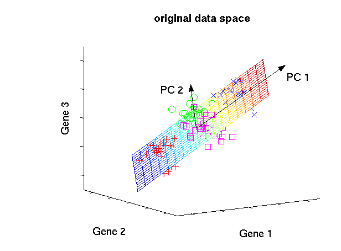

- Now, you may also note that most of this data seems related, it falls close to a 2D plane and just by looking at the spread of the data we  can visualize that the original three dimensions have some correlation.
- So we can instead choose to create two new dimensions, made up of linear combinations of the original three dimensions.
- These dimensions are represented by the two axes/lines, centered in the data. 

- 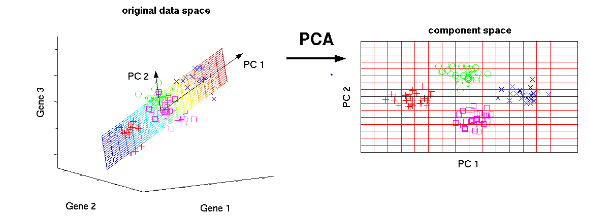
- If we project this in a new 2D space we can see that we still capture most of the original data variance using *just* two dimensions.
- There is a tradeoff between the amount of variance we can capture and the number of component-dimensions we use to represent our data.

- When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance.
- In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

In [33]:
# looking at top 7 components
n_principal_components = 7

#show the variance%
start_idx = N_COMPONENTS - n_principal_components  
print(s.iloc[start_idx:, :])

            0
26   6.392514
27   7.695221
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


## Calculate the explained variance

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}


In [34]:
# Calculate the explained variance for the top n principal components

def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components 
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

## Test Cell

In [35]:
# select a value for the number of top components
n_top_components = 7 

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80167246


In [36]:
# features
features_list = counties_scaled.columns.values
print('Features: \n', features_list)
#this is to look a look of how many dimension we have 
#decide what top-k no. compoent should we try

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


## Get the Component Makeup

In [37]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    row_idx = N_COMPONENTS-component_num
    v_1_row = v.iloc[:, row_idx] #get the Series
    
    v_1 = np.squeeze(v_1_row.values)
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [82]:
v_1_row = v.iloc[:, 32]
v_1_row

0     0.005046
1     0.004953
2     0.005136
3     0.392619
4    -0.601972
5     0.207530
6     0.038430
7    -0.004536
8     0.001652
9     0.004569
10   -0.197683
11   -0.031813
12   -0.196273
13   -0.027649
14    0.331000
15    0.343020
16   -0.097242
17    0.144442
18    0.029167
19    0.015060
20   -0.007183
21    0.011044
22    0.040607
23    0.007401
24   -0.004034
25    0.013728
26   -0.078116
27    0.054965
28    0.003422
29   -0.103600
30    0.141610
31   -0.063451
32   -0.014286
33    0.233627
Name: 32, dtype: float32

In [79]:
v_1_row.values.shape


(34,)

In [88]:
comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])
comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(10)

sorted_weight_data

,weights,features,abs_weights
4,-0.601972,White,0.601972
3,0.392619,Hispanic,0.392619
15,0.343020,ChildPoverty,0.343020
14,0.331000,Poverty,0.331000
33,0.233627,Unemployment,0.233627
5,0.207530,Black,0.207530
10,-0.197683,Income,0.197683
12,-0.196273,IncomePerCap,0.196273
17,0.144442,Service,0.144442
30,0.141610,PublicWork,0.141610


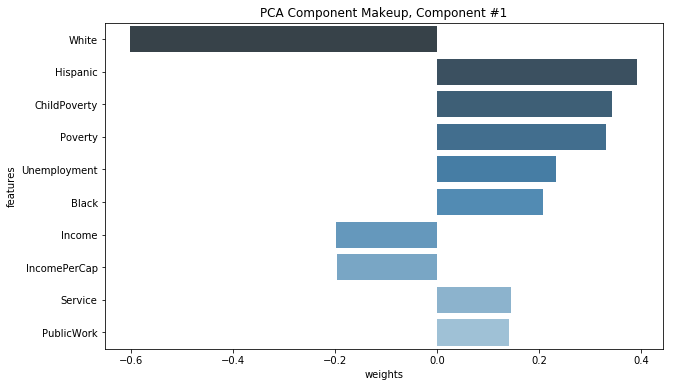

In [71]:
# display makeup of first component
num=1 

display_component(v, counties_scaled.columns.values, component_num=num, n_weights=10)

## Deploying the PCA Model

In [39]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.medium')

---------------------------------------------------------------------------------------------------------------!CPU times: user 588 ms, sys: 52.2 ms, total: 640 ms
Wall time: 9min 20s


In [40]:
train_pca = pca_predictor.predict(train_data_np)

In [90]:
train_data_np.shape

(3218, 34)

In [42]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: 0.0002009272575378418
      values: 0.0002455431967973709
      values: -0.0005782842636108398
      values: -0.0007815659046173096
      values: -0.00041911262087523937
      values: -0.0005133943632245064
      values: -0.0011316537857055664
      values: 0.0017268601804971695
      values: -0.005361668765544891
      values: -0.009066537022590637
      values: -0.008141040802001953
      values: -0.004735097289085388
      values: -0.00716288760304451
      values: 0.0003725700080394745
      values: -0.01208949089050293
      values: 0.02134685218334198
      values: 0.0009293854236602783
      values: 0.002417147159576416
      values: -0.0034637749195098877
      values: 0.01794189214706421
      values: -0.01639425754547119
      values: 0.06260128319263458
      values: 0.06637358665466309
      values: 0.002479255199432373
      values: 0.10011336207389832
      values: -0.1136140376329422
      values: 0

## Create a transformed DataFrame
```
                     c_1	     c_2	       c_3	       c_4	      c_5	   ...
Alabama-Autauga	-0.060274	0.160527	-0.088356	 0.120480	-0.010824	...
Alabama-Baldwin	-0.149684	0.185969	-0.145743	-0.023092	-0.068677	...
Alabama-Barbour	0.506202	 0.296662	 0.146258	 0.297829	0.093111	...
...
```

In [43]:
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    counties_transformed=pd.DataFrame()

    for data in train_pca:
        components=data.label['projection'].float32_tensor.values        
        counties_transformed=counties_transformed.append([list(components)])

    counties_transformed.index=counties_scaled.index
    start_idx = N_COMPONENTS - n_top_components #33-7=26
    counties_transformed = counties_transformed.iloc[:,start_idx:]
    
    return counties_transformed.iloc[:, ::-1]    

In [44]:
for data in train_pca:
    components=data.label['projection'].float32_tensor.values
    
print(len(components))    
components  

33


[-0.000654757022857666, 0.00013604480773210526, -0.00026100873947143555, 0.0001394897699356079, 0.0003648325800895691, -0.00041757989674806595, -0.00026917457580566406, -0.0028925910592079163, 0.028181545436382294, 0.03708241879940033, 0.02710176259279251, 0.051435306668281555, -0.005154360085725784, -0.03608216717839241, 0.006326526403427124, -0.06152985244989395, 0.011016786098480225, -0.014538764953613281, -0.1959279477596283, -0.11836785078048706, 0.07032856345176697, -0.04138663411140442, -0.04780998453497887, -0.048552945256233215, 0.11315615475177765, 0.0024667978286743164, 0.13741451501846313, 0.09599125385284424, -0.18122105300426483, -0.4469303786754608, -0.15114396810531616, -0.18681234121322632, 1.3912105560302734]

In [48]:
# specify top n
top_n = 7

counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)
counties_transformed.head()

,32,31,30,29,28,27,26
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


In [49]:
# add descriptive columns
PCA_list=['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7']
counties_transformed.columns=PCA_list 

counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


### Delete the Endpoint

In [50]:
session.delete_endpoint(pca_predictor.endpoint)

## Population Segmentation 

## Choosing a "Good" K
- 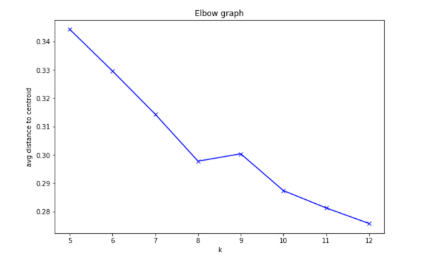

## Define/Create k-means estimator


In [52]:
# define a KMeans estimator
from sagemaker import KMeans

NUM_CLUSTERS = 8

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)

## Convert training data

In [53]:
kmeans_train_data_np = counties_transformed.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

## Train the k-means model

In [54]:
%%time
kmeans.fit(kmeans_formatted_data)

2019-08-19 17:23:55 Starting - Starting the training job...
2019-08-19 17:23:57 Starting - Launching requested ML instances.........
2019-08-19 17:25:30 Starting - Preparing the instances for training......
2019-08-19 17:26:54 Downloading - Downloading input data...
2019-08-19 17:27:23 Training - Training image download completed. Training in progress..
Docker entrypoint called with argument(s): train
[08/19/2019 17:27:26 INFO 139814817576768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["ms


2019-08-19 17:27:36 Uploading - Uploading generated training model
2019-08-19 17:27:36 Completed - Training job completed
Billable seconds: 42
CPU times: user 471 ms, sys: 31.7 ms, total: 502 ms
Wall time: 4min 12s


##  Deploy the k-means model

In [55]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

---------------------------------------------------------------------------------------------------------------------------!CPU times: user 596 ms, sys: 71.7 ms, total: 668 ms
Wall time: 10min 21s


## Pass in the training data and generate predicted cluster labels

In [115]:
cluster_info=kmeans_predictor.predict(kmeans_train_data_np)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint kmeans-2019-08-19-17-23-55-092 of account 976575622760 not found.

In [92]:
len(cluster_info)

3218

In [97]:
cluster_info[0]

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2795764207839966
    }
  }
}

## Exploring the resultant clusters

In [57]:
# print cluster info for first data point
data_idx = 0

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

#its closest cluster is cluster no.1
#also can see the Euclidean distance to that cluster.

County is:  Alabama-Autauga

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.2795764207839966
    }
  }
}



## Visualize the distribution of data over clusters

In [58]:
# get cluster label for each point
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [59]:
# count how many data points fall into each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()
print(cluster_df)

0.0    800
6.0    772
3.0    475
1.0    426
4.0    395
5.0    223
2.0     91
7.0     36
Name: 0, dtype: int64


## Visualize distribution with histogram

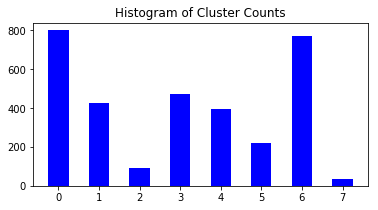

In [60]:
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=8,  range=(-0.5, 7.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

### Delete the Endpoint!

In [61]:
session.delete_endpoint(kmeans_predictor.endpoint)

## Access the k-means model attributes

In [62]:
# download and unzip the kmeans model file
kmeans_job_name = 'kmeans-2019-08-19-10-43-35-856'

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')
model_key

'counties/kmeans-2019-08-19-10-43-35-856/output/model.tar.gz'

In [63]:
#download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1') 

2304

## MXNet to load the model artifacts aray

In [64]:
#load the model details using MXNet library
#get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

[
[[-0.15732624  0.09310568  0.01215584 -0.05687043 -0.05991276 -0.05242625
  -0.01089352]
 [ 0.38352522  0.23151875  0.10131267  0.27170724  0.10843702 -0.04660173
   0.04143313]
 [-0.03909319  0.0823268   0.18024316 -0.07670085  0.00626679  0.10492503
  -0.02855384]
 [ 1.3060359  -0.23646036 -0.16877016 -0.4264142  -0.11719605  0.10705096
   0.15191701]
 [ 0.29970184 -0.19941685 -0.09898262 -0.16061902  0.13319804 -0.1124692
  -0.06513329]
 [-0.22977124 -0.32067236  0.07337292  0.06746715  0.0220743  -0.02665976
   0.05997429]
 [-0.1315014   0.04792948 -0.3295887   0.06771228 -0.00728787  0.08208545
  -0.00552209]
 [ 0.5236202  -0.49603394  0.1637444   0.3683548  -0.28151774  0.05528873
  -0.28482994]]
<NDArray 8x7 @cpu(0)>]


In [65]:
# get all the centroids from the model attribute array
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())

cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,-0.157326,0.093106,0.012156,-0.056870,-0.059913,-0.052426,-0.010894
1,0.383525,0.231519,0.101313,0.271707,0.108437,-0.046602,0.041433
2,-0.039093,0.082327,0.180243,-0.076701,0.006267,0.104925,-0.028554
3,1.306036,-0.236460,-0.168770,-0.426414,-0.117196,0.107051,0.151917
4,0.299702,-0.199417,-0.098983,-0.160619,0.133198,-0.112469,-0.065133
5,-0.229771,-0.320672,0.073373,0.067467,0.022074,-0.026660,0.059974
6,-0.131501,0.047929,-0.329589,0.067712,-0.007288,0.082085,-0.005522
7,0.523620,-0.496034,0.163744,0.368355,-0.281518,0.055289,-0.284830


## Visualizing Centroids in Component Space with headmap

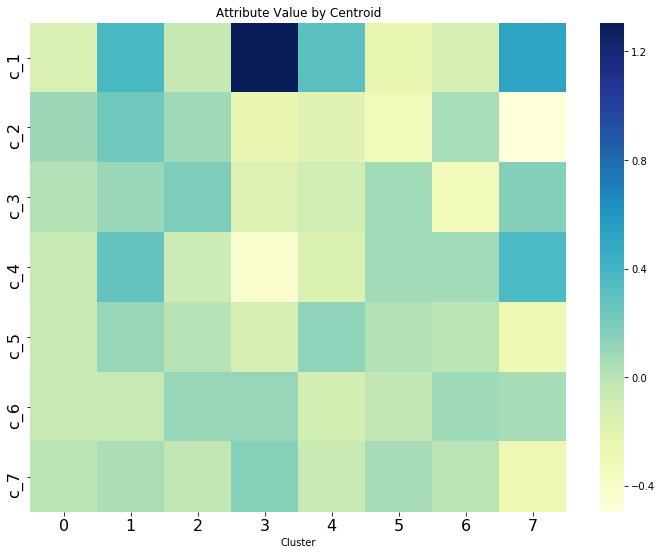

In [114]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')

ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

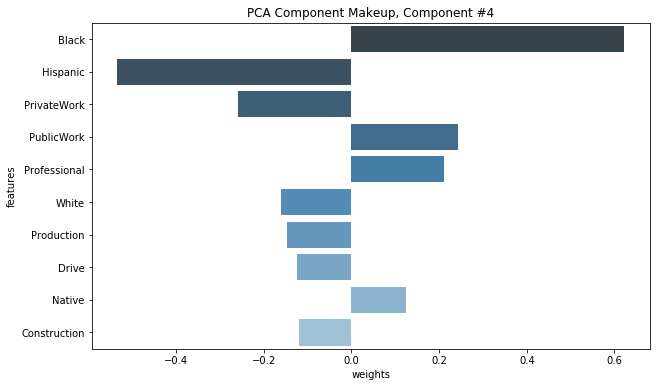

In [67]:
component_num=4
display_component(v, counties_scaled.columns.values, component_num=component_num)

## Natural Groupings

In [68]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
sorted_counties.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Illinois-Massac,-0.094682,0.121152,0.118248,-0.049285,-0.100886,-0.079333,0.006295,0
Idaho-Gem,-0.018072,-0.111845,0.131020,-0.016613,-0.073640,0.253401,0.001423,0
Texas-Cass,0.076995,0.203400,0.142370,-0.010721,0.003931,-0.010209,0.091680,0
Kentucky-Crittenden,-0.120178,0.070215,0.280297,-0.107292,0.060769,0.104270,-0.005336,0
Texas-Callahan,-0.102561,-0.027988,0.128375,-0.105158,0.007324,-0.006261,0.064468,0
Texas-Burnet,-0.001310,-0.103779,-0.037240,-0.113198,0.067212,0.058054,0.021098,0
Texas-Burleson,0.113557,-0.035419,-0.008676,-0.015108,0.191116,0.072753,-0.024934,0
Texas-Brown,0.055732,-0.018321,-0.007340,-0.104240,-0.117460,-0.148945,0.067528,0
Kentucky-Clinton,-0.045153,0.094193,0.345715,-0.118339,-0.127935,-0.067662,-0.006697,0
Kentucky-Clay,0.263388,0.151914,0.455163,-0.080330,-0.152350,0.271387,-0.052811,0


In [69]:
# get all counties with label == 1
cluster=counties_transformed[counties_transformed['labels']==1]
cluster.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895,1
Alabama-Elmore,-0.012876,0.149734,-0.093516,0.159915,0.005184,0.111085,0.035451,1
Alabama-Lee,0.064896,0.128287,-0.106076,0.188930,-0.097875,-0.055361,0.103783,1
Alabama-Madison,-0.040161,0.098388,-0.303515,0.247782,-0.101594,-0.067664,0.108778,1
Alabama-Shelby,-0.275941,0.164189,-0.419348,0.063357,-0.027054,0.082696,0.083723,1


## Conclusion

- We have walked through a machine learning workflow for unsupervised learning, for clustering a dataset using k-means after reducing the dimensionality using PCA.
- By accessing the underlying models created within  SageMaker, we were able to improve the explainability of your model and draw insights from the resultant clusters. 

- Using these techniques, we have been able to better understand the essential characteristics of different counties in the US and segment them into similar groups accordingly.